In [4]:
####
import os
os.getcwd()
import numpy as np
import sys
import multiprocessing  

# Change to your code directory location
os.chdir('/Users/amandabuch/Documents/clusterCCA/PCMF/')

import pandas as pd

import mosek
import cvxpy as cp
import time
from itertools import combinations
from admm_utils import prox as cprox
from pcmf import pcmf_full, pcmf_approx_uV
from sklearn.preprocessing import StandardScaler

import argparse

import sys
from datetime import datetime as dt
import pandas as pd
from shutil import copyfile

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict
np.random.seed(1234)

from numba import jit, prange

from p3ca import generate_cluster_cca_data


In [5]:
###------- PATHWISE ADMM CCA -------###
from scipy.sparse import csr_matrix
from sksparse.cholmod import cholesky, cholesky_AAt
def sparse_D(n,p):
    '''
    Construct a sparse matrix, that when applied to a vector containing concatenated vectors
    of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are 
    n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)
    across all unique pairwise combinations of vectors. 
    '''
    comb_list = list(combinations(range(n),2))
    combs_arr = np.array(comb_list)
    num_combs = combs_arr.shape[0]
    data = np.ones_like(combs_arr)
    data[:,1] *= -1
    row = np.repeat(range(num_combs),2)
    col = combs_arr.flatten()
    return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n))

def chol_D(num_obs, num_vars, rho):
    D = sparse_D(num_obs, num_vars)
    return D, cholesky_AAt(np.sqrt(rho) * D.T, beta=1.0)

def group_soft_threshold(vec,alpha):
    '''
    Soft group thresholding for ADMM
    Params:
        vec
        alpha
    Returns:
        np.asarray(V_prox)
    '''
    if np.linalg.norm(vec) > alpha:
        return vec - alpha*vec/np.linalg.norm(vec) 
    else:
        return np.zeros_like(vec)

def prox(V, lamb, rho, w=None):
    if w is None:
        w = np.ones(V.shape[0])
    V_prox = []
    for i in range(V.shape[0]):
        alpha = w[i]*lamb/rho
        V_prox.append(group_soft_threshold(V[i,:],alpha))
    return np.asarray(V_prox)  


@jit(nopython=True, parallel=True, fastmath=True)
def prox_numba_arr(V_prox, V, lamb, rho, w=None):
    '''
    Numba formulation of Proximal operator for group sparse thresholding.
    '''
#     print(V_prox)
#     print(w)
    if w is None:
        w = np.ones(V.shape[0])
    for i in prange(V.shape[0]):
        if np.isinf(lamb):
            alpha = lamb/rho
        else:
            alpha = w[i]*lamb/rho
#         print(alpha)
        # group_soft_threshold
        vec_norm = np.linalg.norm(V[i,:])
#         print(alpha)
        if vec_norm > alpha:
#             print(vec_norm > alpha)
            V_prox[i, :] = V[i,:] - alpha*V[i,:]/vec_norm
        else:
            V_prox[i, :] = np.zeros_like(V[i,:])
#     print(V_prox)
    return V_prox

def l2_ball_proj(X):
    '''
    Normalize rows of X to satisfy $\|X_{i,\cdot}\|_2^2 \leq 1$.
    '''
    def row_norm(vec): 
        return np.sqrt(1./np.sum(vec**2)) * vec
    return np.apply_along_axis(row_norm,1,X)

def get_weights(X, gauss_coef=0.5, neighbors=None):
    '''
    Weights for ADMM
    Params:
        X
        gauss_coef
        neighbors
    Returns:
        w = weights of shape ()
    '''
    from scipy.spatial.distance import pdist, squareform
    dist_vec = pdist(X)
    w = np.exp(-1*gauss_coef*dist_vec**2)
    if neighbors is not None:
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=neighbors, algorithm='ball_tree').fit(X)
        _, indices = nbrs.kneighbors(X)
        comb_list = list(combinations(range(X.shape[0]),2))
        neighbors_indicator = []
        for comb in comb_list:
            nn_i = indices[comb[0],:]
            if comb[1] in nn_i:
                neighbors_indicator.append(1.0)
            else:
                neighbors_indicator.append(0.0)
        w *= np.array(neighbors_indicator)
    return w

def admm_CCA_update(mat_tilde, chol_factor, D, W, Z, rho, penalty, data, weights=False, neighbors=None,gauss_coef=0.5, numba=True):
    '''
    Updates V, W, and Z for ADMM
    Params:
        mat_tilde
        chol_factor
        D
        W
        Z
        rho
        penalty
        data
        weights
        neighbors
    Returns:
        V
        W
        Z
    '''
    if weights is False:
        weights = get_weights(data,gauss_coef=0.0)
    else:
        weights = get_weights(data,gauss_coef=gauss_coef, neighbors=neighbors)
    V = chol_factor(mat_tilde + rho*D.T*(W - Z))
#     W = prox(D*V+Z, penalty, rho, weights)
    if numba==True:
        W = prox_numba_arr(np.zeros_like(W), D*V+Z, penalty, rho, weights)
    else:
        W = cprox(D*V+Z, penalty, rho, weights)
    Z = Z + D*V - W
    V = l2_ball_proj(V)

    return V, W, Z

In [6]:
def admm_CCA_new_2(X, Y, penalty_list, rho=1.0, admm_iters = 2, cca_iters = 3, weights=False, neighbors=None, gauss_coef=0.5, verb=True, non_negative=False, parallel=False, output_file='', numba=True):
    '''
    Main function to run ADMM-version of PCMF-CCA, runs along penalty path penalty_list
    Params:
        X
        Y
        penalty_list
        rho
        admm_iters = number of admm updates for each u and each v
        cca_iters = number of u / v updates
        weights
        neighbors
        verb = whether to print output of iteratino and penalty at each outer iter
    Returns:
    '''
    # Initialize U as X and V as Y
    Dx, chol_factor_X = chol_D(X.shape[0], X.shape[1], rho)
    Wx = Zx = Dx*X
    Dy, chol_factor_Y = chol_D(Y.shape[0], Y.shape[1], rho)
    Wy = Zy = Dy*Y
    
    U_list = []
    V_list = []
    Zx_list = []
    Zy_list = []    
    Wx_list = []
    Wy_list = []
    penalty = penalty_list[0]
    
    # Initial U update
    if penalty_list[0] > penalty_list[-1]:
        V_initial = np.tile(np.mean(Y,axis=0),Y.shape[0]).reshape(Y.shape)
    else:
        V_initial = Y.copy()
    Xu_tildes = []
    for i in range(X.shape[0]):
        Xu_tildes.append(np.dot(np.outer(X[i,:].T,Y[i,:]),V_initial[i,:]))
    Xu = np.asarray(Xu_tildes)
    U, Wx, Zx = admm_CCA_update(Xu, chol_factor_X, Dx, Wx, Zx, rho, penalty, X, weights=weights, neighbors=neighbors, numba=numba, gauss_coef=gauss_coef)
    # U_list.append(U)

    # Initial V update
    if penalty_list[0] > penalty_list[-1]:
        U_initial = np.tile(np.mean(X,axis=0),X.shape[0]).reshape(X.shape)
    else:
        U_initial = X.copy()
    Yv_tildes = []
    for i in range(Y.shape[0]):
        Yv_tildes.append(np.dot(np.outer(Y[i,:].T,X[i,:]),U_initial[i,:]))
    Yv = np.asarray(Yv_tildes)
    V, Wy, Zy = admm_CCA_update(Yv, chol_factor_Y, Dy, Wy, Zy, rho, penalty, Y, weights=weights, neighbors=neighbors, numba=numba, gauss_coef=gauss_coef)
    # V_list.append(V)

#     U = U_initial
#     V = V_initial
    try:
        for i in range(len(penalty_list)):
            penalty = penalty_list[i]
            print_progress = verb
            if print_progress == True:
                # # print("[",i+1,"]",round(penalty,5), end="")
                # print("[",i+1,"]","{:.25e}".format(penalty), end="")
                # print("...", end="")
                if parallel == True:
                    file1 = open(output_file, "a")
                    file1.write(str([i+1])+" {:.5e}".format(penalty))
                    file1.write("...")
                    file1.close()
                else:
                    print("[",i+1,"]","{:.5e}".format(penalty), end="")
                    print("...", end="")

            for it in range(cca_iters):
                # U update
                for it in range(admm_iters):
                    Xu_tildes = []
                    for i in range(X.shape[0]):
                        
                        Xu_tildes.append(np.dot(np.outer(X[i,:].T,Y[i,:]),V[i,:]))
                    Xu = np.asarray(Xu_tildes)

                    U, Wx, Zx = admm_CCA_update(Xu, chol_factor_X, Dx, Wx, Zx, rho, penalty, X, weights=weights, neighbors=neighbors, gauss_coef=gauss_coef)
                    if non_negative:
                        U[U<0] = 0

                # V update
                for it in range(admm_iters):
                    Yv_tildes = []
                    for i in range(X.shape[0]):
                        Yv_tildes.append(np.dot(np.outer(Y[i,:].T,X[i,:]),U[i,:]))
                    Yv = np.asarray(Yv_tildes)

                    V, Wy, Zy = admm_CCA_update(Yv, chol_factor_Y, Dy, Wy, Zy, rho, penalty, Y, weights=weights, neighbors=neighbors, gauss_coef=gauss_coef)
                    if non_negative:
                        V[V<0] = 0

            U_list.append(U)
            V_list.append(V)
            Wx_list.append(Wx)
            Wy_list.append(Wy)
            Zx_list.append(Zx)
            Zy_list.append(Zy)
            
    except KeyboardInterrupt:
        print("KeyboardInterrupt has been caught.")

    return U_list, V_list, Wx_list, Wy_list, Zx_list, Zy_list



In [7]:
def data_non_overlapping(density=1, sigma=0.1, m=50):
    # Get clustered CCA data
    X_clusters, Y_clusters, u_true, v_true, _ = generate_cluster_cca_data(m=m, n_X=200, n_Y=200, n_clusters=2, sigma=sigma, density=density, cluster_means=[0.2,-0.2], diff_means=True)
    X_c = np.vstack(X_clusters)
    Y_c = np.vstack(Y_clusters)
    true_clusters = np.repeat([0,1],m)

    scaler = StandardScaler()
    scaler.fit(X_c)
    X_c = scaler.transform(X_c)

    scaler = StandardScaler()
    scaler.fit(Y_c)
    Y_c = scaler.transform(Y_c)
    
    return X_c, Y_c, true_clusters, u_true, v_true



In [8]:
def data_non_overlapping_5(density=1, sigma=0.1, m=20):
    # Get clustered CCA data
    cmeans=[-1.5, 1.5, 0.0, 0.01, -0.4]
    X_clusters, Y_clusters, u_true, v_true, _ = generate_cluster_cca_data(m=m, n_X=20, n_Y=20, n_clusters=5, sigma=sigma, density=density, cluster_means=cmeans, diff_means=True,seeds_clusters=[0,1,2,3,4])
    X_c = np.vstack(X_clusters)
    Y_c = np.vstack(Y_clusters)
    true_clusters = np.repeat([0,1,2,3,4],m)

    scaler = StandardScaler()
    scaler.fit(X_c)
    X_c = scaler.transform(X_c)

    scaler = StandardScaler()
    scaler.fit(Y_c)
    Y_c = scaler.transform(Y_c)
    
    return X_c, Y_c, true_clusters, u_true, v_true




In [9]:
X, Y, true_clusters, _, _ = data_non_overlapping_5(density=1, sigma=0.1)
n_infinities = 2
penalty_list=np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-20,50,50))[::-1]), axis=0)
U_list, V_list, Wx_list, Wy_list, Zx_list, Zy_list = admm_CCA_new_2(X, Y, penalty_list, rho=1.0, admm_iters = 2, cca_iters = 3, neighbors=25, gauss_coef=2.0)
    
    

generating seeds
generating seeds
generating seeds
generating seeds
generating seeds
[ 1 ] inf...[ 2 ] inf...[ 3 ] 5.18471e+21...[ 4 ] 1.24252e+21...[ 5 ] 2.97771e+20...[ 6 ] 7.13612e+19...[ 7 ] 1.71018e+19...[ 8 ] 4.09846e+18...[ 9 ] 9.82200e+17...[ 10 ] 2.35385e+17...[ 11 ] 5.64103e+16...[ 12 ] 1.35188e+16...[ 13 ] 3.23979e+15...[ 14 ] 7.76420e+14...[ 15 ] 1.86070e+14...[ 16 ] 4.45918e+13...[ 17 ] 1.06865e+13...[ 18 ] 2.56102e+12...[ 19 ] 6.13752e+11...[ 20 ] 1.47086e+11...[ 21 ] 3.52494e+10...[ 22 ] 8.44755e+09...[ 23 ] 2.02447e+09...[ 24 ] 4.85165e+08...[ 25 ] 1.16270e+08...[ 26 ] 2.78643e+07...[ 27 ] 6.67771e+06...[ 28 ] 1.60032e+06...[ 29 ] 3.83518e+05...[ 30 ] 9.19106e+04...[ 31 ] 2.20265e+04...[ 32 ] 5.27867e+03...[ 33 ] 1.26504e+03...[ 34 ] 3.03168e+02...[ 35 ] 7.26544e+01...[ 36 ] 1.74117e+01...[ 37 ] 4.17273e+00...[ 38 ] 1.00000e+00...[ 39 ] 2.39651e-01...[ 40 ] 5.74326e-02...[ 41 ] 1.37638e-02...[ 42 ] 3.29851e-03...[ 43 ] 7.90490e-04...[ 44 ] 1.89442e-04...[ 45 ] 4.53999e-

/var/folders/qr/4h9z0q0n3q91c263nytvrm1c0000gn/T/ipykernel_31499/768642752.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/var/folders/qr/4h9z0q0n3q91c263nytvrm1c0000gn/T/ipykernel_31499/768642752.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/var/folders/qr/4h9z0q0n3q91c263nytvrm1c0000gn/T/ipykernel_31499/768642752.py:71: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
/var/folders/qr/4h9z0q0n3q91c263nytvrm1c0000gn/T/ipykernel_31499/768642752.py:95: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Ma

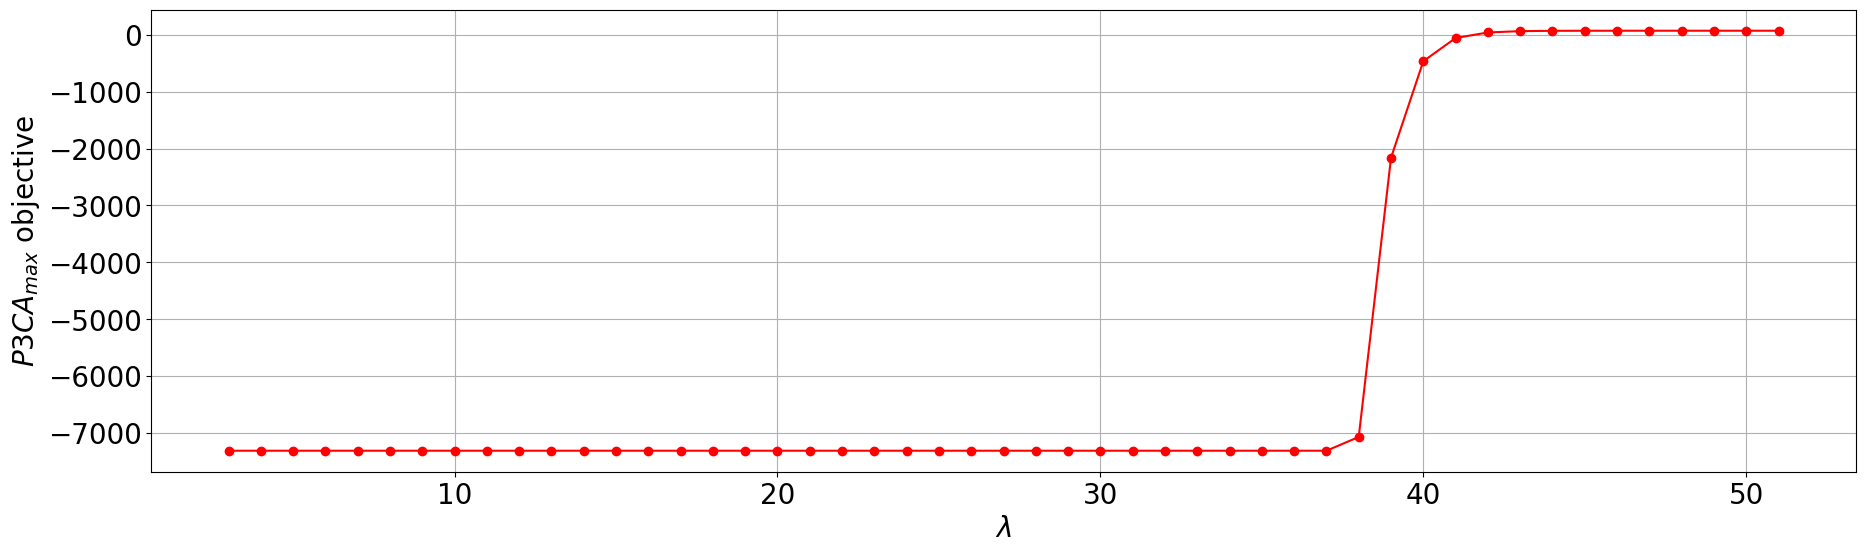

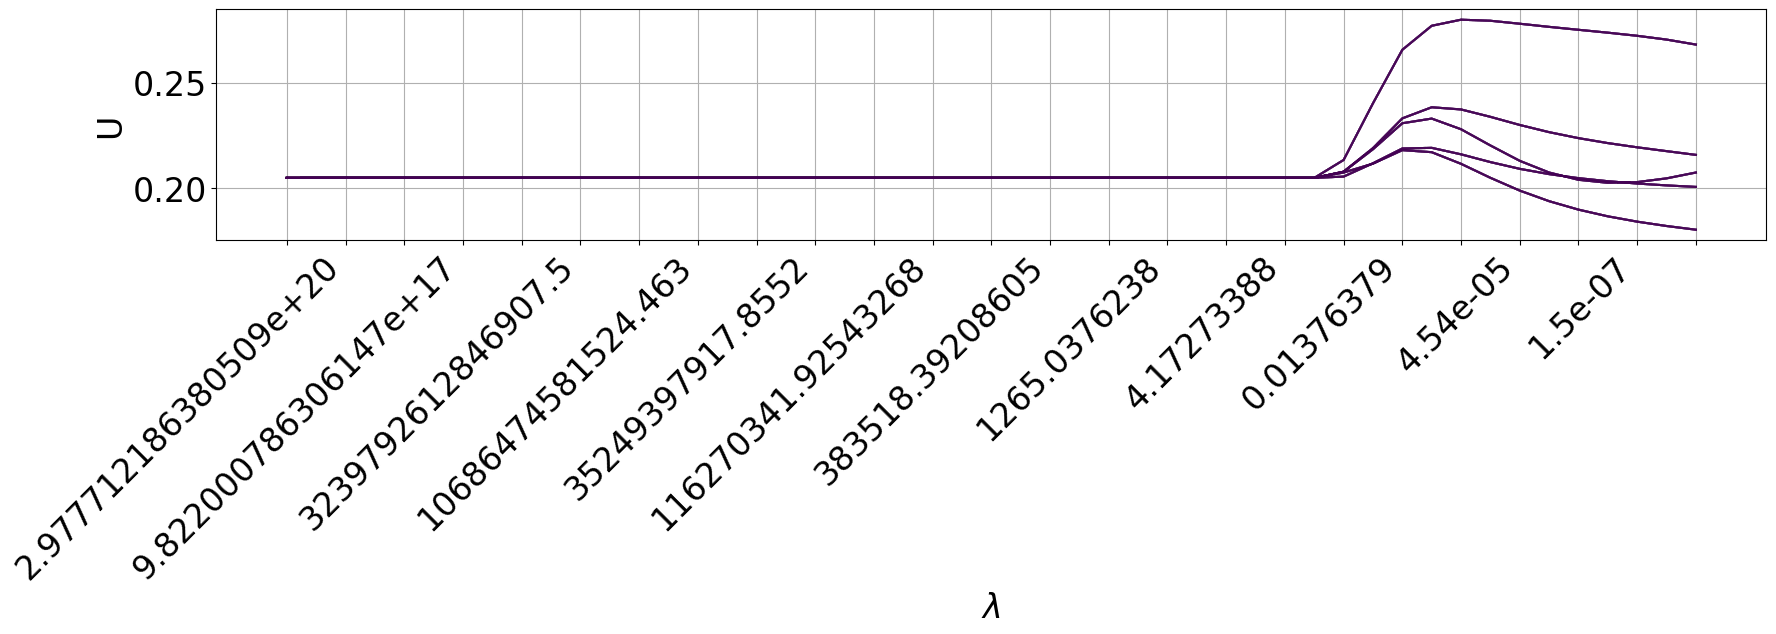

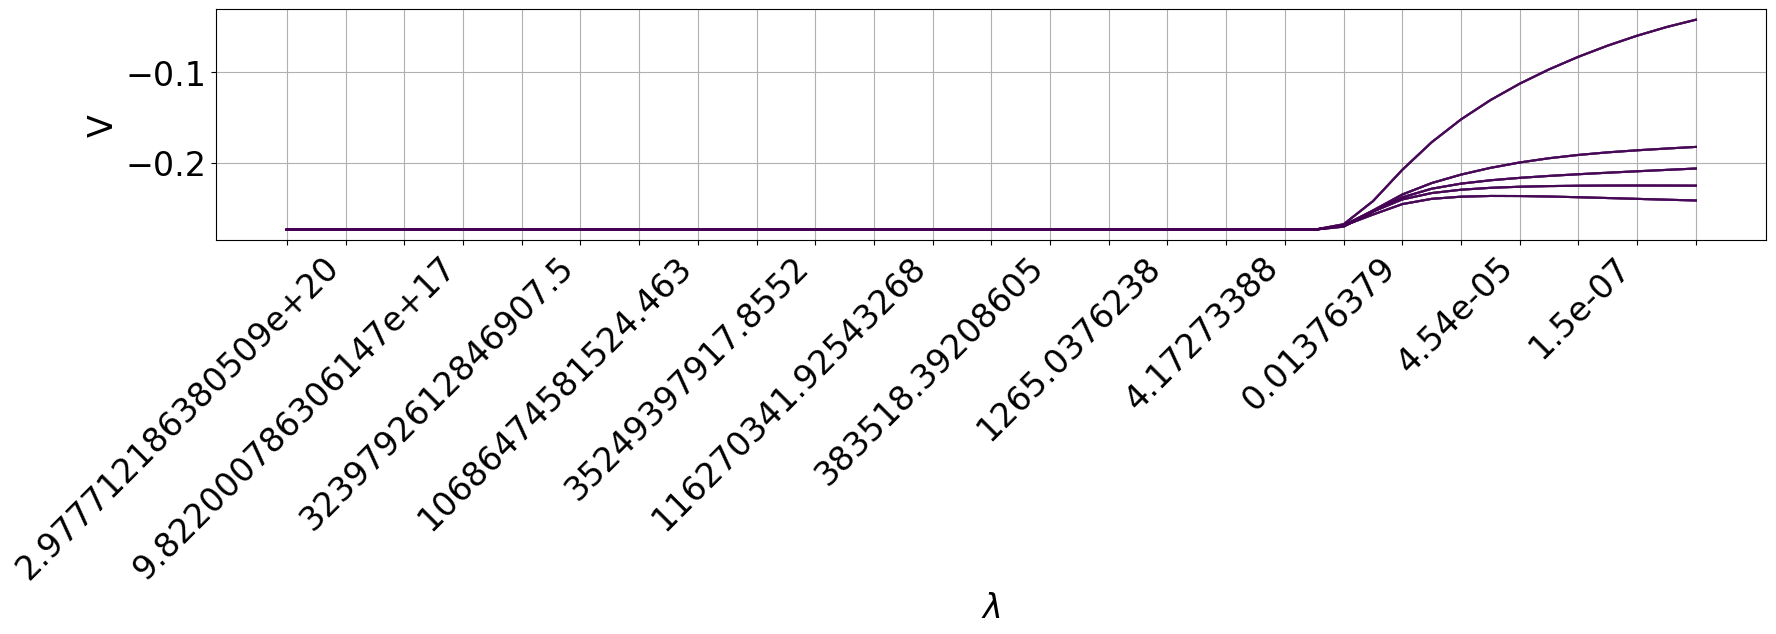

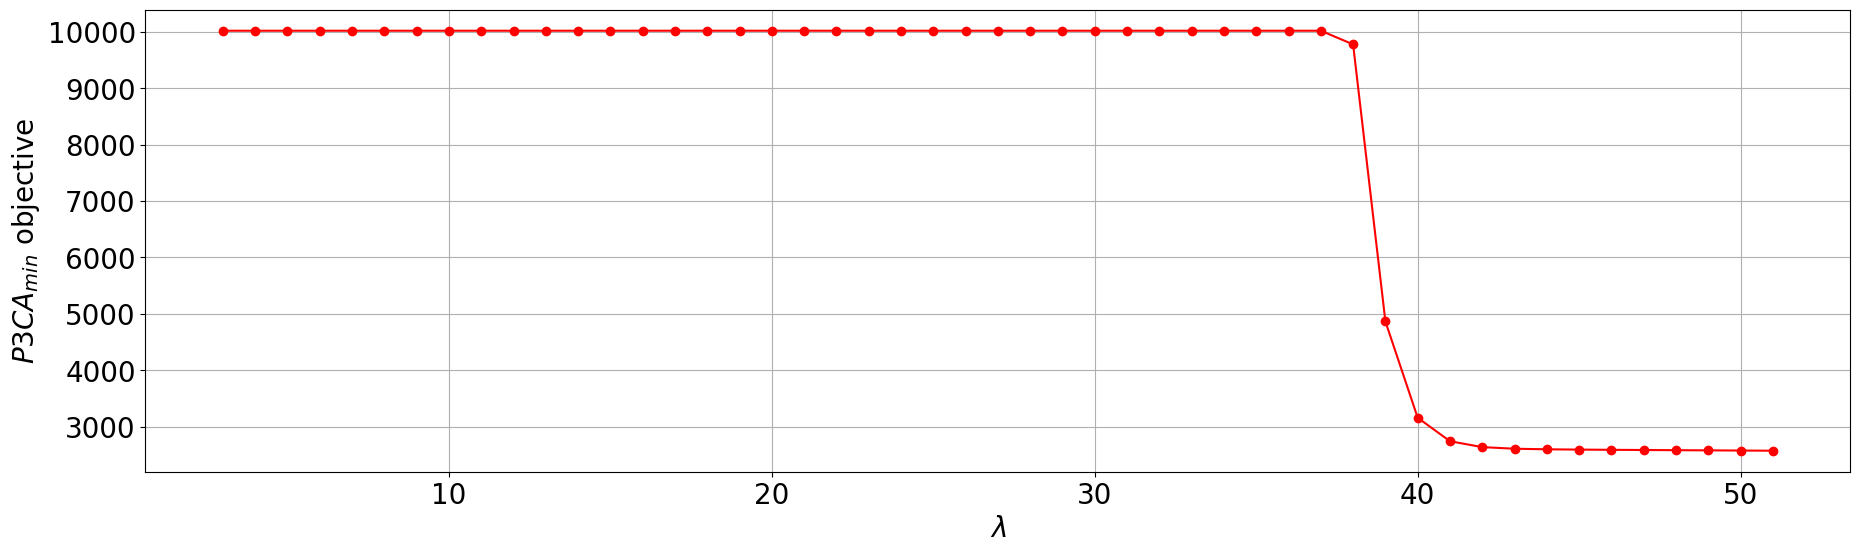

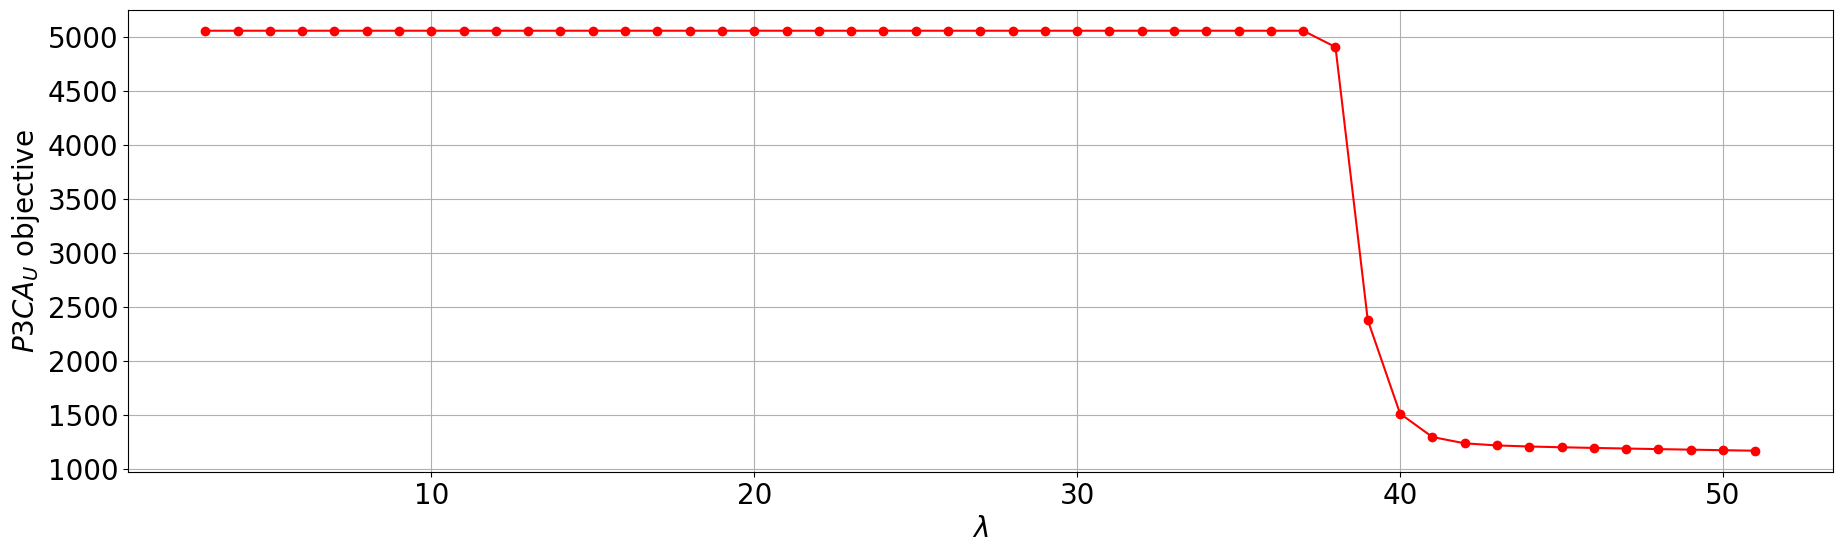

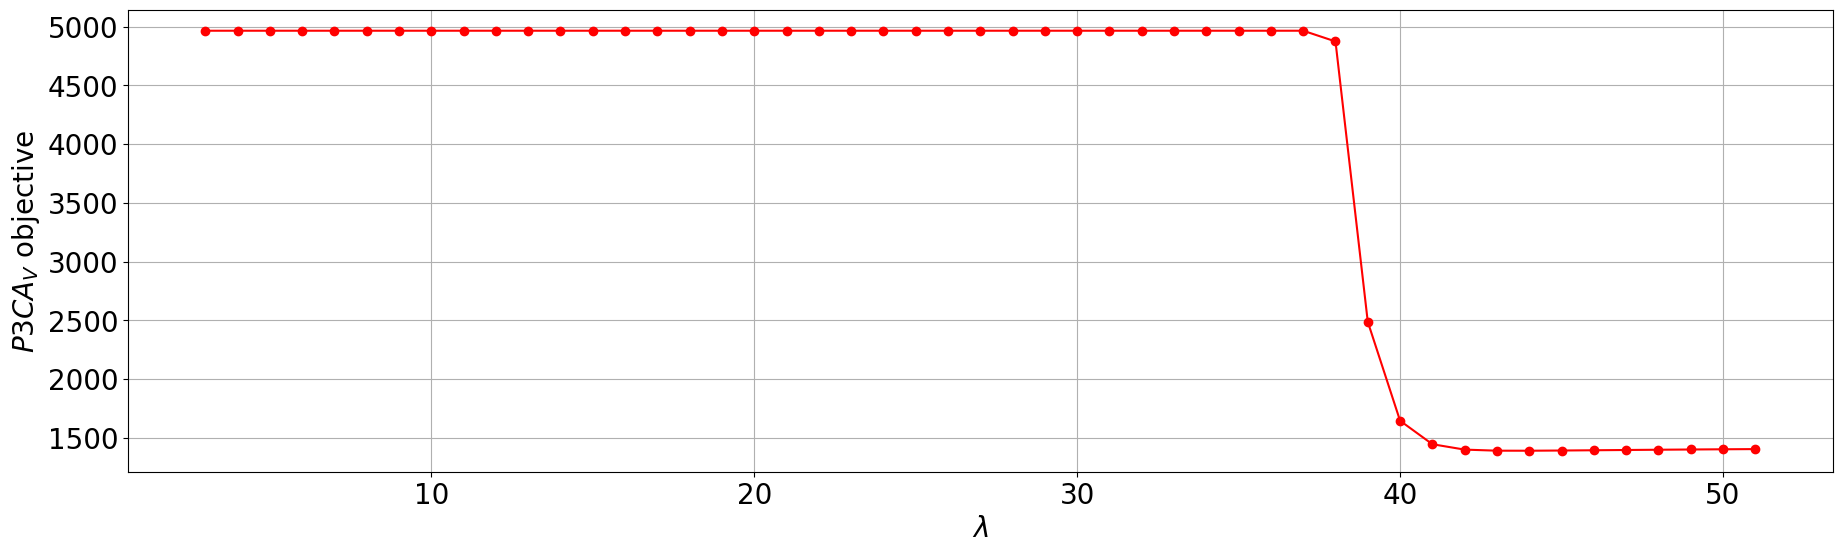

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm


def plot_dendrogram(Xhat,problem_rank,true_clusters_all,n_infinities,penalty_list,ylabel=False):
    from pcmf import centroid_matrix
    Xhat_centroids = []
    for p in range(len(penalty_list)):
        Xhat_centroids.append(centroid_matrix(np.array(Xhat[p]),true_clusters_all))
    path_plot(np.asarray(Xhat_centroids)[:,:,0:1], penalty_list, plot_range=[n_infinities,-1])
    if ylabel==False:
        plt.ylabel("$\hat{X}$ Rank "+str(problem_rank))
    else:
        plt.ylabel(ylabel)
    plt.locator_params(axis='x',nbins=25)
    ax = plt.gca()
    ax.patch.set_facecolor('white')
    plt.grid(b=None)
    fig = plt.gcf()
    fig.set_figheight(3)
    
from pcmf import path_plot, plot_cluster_assignments, two_cluster_data, pcmf_full



UXYVs = list()
for lam in penalty_list:
    UXYV = list()
    for i in np.arange(X.shape[0]):
        UXYV.append(U_list[0][i,:]*X[i,:].T*Y[i,:]*V_list[0][i,:])
    UXYVs.append(np.array(UXYV))


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$P3CA_{max}$ objective',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0
fontsize=20 

P_list = []
k_min = n_infinities+1; k_max = len(UXYVs)
for k in np.arange(k_min,k_max,1):
    penalty = penalty_list[k]
    P_list.append(np.sum(np.sum(np.abs(UXYVs[k]), axis=1)) - np.sum(np.sum(np.abs(Zx_list[k]), axis=1)) - np.sum(np.sum(np.abs(Zy_list[k]), axis=1)) )

P = np.asarray(P_list)
s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);


# Plot true cluster centroid dendrograms
plot_dendrogram(U_list,1,true_clusters,n_infinities,penalty_list,ylabel='U')
plot_dendrogram(V_list,1,true_clusters,n_infinities,penalty_list,ylabel='V')


fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$P3CA_{min}$ objective',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0
fontsize=20 

P_list = []
k_min = n_infinities+1; k_max = len(UXYVs)
for k in np.arange(k_min,k_max,1):
    penalty = penalty_list[k]
    P_list.append(np.linalg.norm(X - U_list[k], 2)**2  + np.linalg.norm(Y - V_list[k], 2)**2  + np.sum(np.sum(np.abs(Zx_list[k]), axis=1)) + np.sum(np.sum(np.abs(Zy_list[k]), axis=1)) )
              
              
P = np.asarray(P_list)
s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$P3CA_{U}$ objective',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0
fontsize=20 

P_list = []
k_min = n_infinities+1; k_max = len(UXYVs)
for k in np.arange(k_min,k_max,1):
    penalty = penalty_list[k]
    P_list.append(np.linalg.norm(X - U_list[k], 2)**2  + np.sum(np.sum(np.abs(Zx_list[k]), axis=1)))     
              
P = np.asarray(P_list)
s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('white')
plt.xlabel('$\lambda$',fontsize=20)
plt.ylabel('$P3CA_{V}$ objective',fontsize=20)
plt.grid(b=None)
colors = cm.rainbow(np.linspace(1, 0, 52))
c = 0
fontsize=20 

P_list = []
k_min = n_infinities+1; k_max = len(UXYVs)
for k in np.arange(k_min,k_max,1):
    penalty = penalty_list[k]
    P_list.append(np.linalg.norm(Y - V_list[k], 2)**2  + np.sum(np.sum(np.abs(Zy_list[k]), axis=1)))     
              
P = np.asarray(P_list)
s = plt.plot(np.arange(k_min,k_max,1), P,'o-',color=colors[c,:])
c = c+1

plt.xticks(fontsize=fontsize,rotation=0);
plt.yticks(fontsize=fontsize,rotation=0);

# plot_dend